# Sprint 10 A/B Testing

At this online store we need to increase revenue.  This revenue will either come from existing customers, from increasing conversion of non buying visitors or through attracting new customers to the store.  Together with the marketing team we picked nine hypotheses that we will prioritize and test using A/B testing to see which is the more effective.  

We have three datasets to work with:

The hypotheses dataset ('hypot', hypotheses_us.csv) contains the possible hypotheses and evaluation of the reach, impact, confidence and effort of each.  
The orders dataset ('orders', orders_us.csv) contains the identity of who made the order, what group it was in and what was the revenue from it.  
Lastly, the visits ('visits', visits_us.csv) dataset contains data on the number of visits per day from visitors belonging to each test group.

In [6]:
#Import libraries and datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [7]:
hypot = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
hypot.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [8]:
orders = pd.read_csv('/datasets/orders_us.csv')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [10]:
orders.drop_duplicates()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


No duplicates but maybe there are users that show up in both groups.

In [11]:
#two groups for each group
ordersA = orders[orders['group']=='A']
ordersB = orders[orders['group']=='B']

In [12]:
#create a group that has user ids that are present in both groups
common_visitorIds = set(ordersA['visitorId']).intersection(set(ordersB['visitorId']))
#remove those common visitorIds from the orders table
filtered_orders = orders[~orders['visitorId'].isin(common_visitorIds)]

In [13]:
# Create a DataFrame with common visitorId values and their corresponding dates
common_ids_dates = orders[orders['visitorId'].isin(common_visitorIds)][['visitorId', 'date', 'group']]

# Count the duplicates for each date
duplicate_counts = common_ids_dates.groupby(['date', 'group']).size().reset_index(name='duplicate_count')

duplicate_counts.head()

,date,group,duplicate_count
0,2019-08-01,A,1
1,2019-08-01,B,4
2,2019-08-02,A,1
3,2019-08-02,B,1
4,2019-08-03,B,2


In [14]:
#check that it removed those
filtered_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB


In [15]:
#reassign the orders table
orders = filtered_orders

We found buyers that turned up in both group A and B.  This skews our test results so these users need to be removed.


In [16]:
visits = pd.read_csv('/datasets/visits_us.csv')
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Priotitizing Hypotheses

Since A/B testing is lengthy and costly, the hypotheses needed to be testing in order of priority.  We will test them according to the ICE and RICE frameworks.  These considers the (R)each of how many users will be affected by the change, the (I)mpact it will have on our users, the (C)onfidence we have that it will affect them this way, and the (E)ffort it will take to implement this update.
The ideal hypothesis will have the maximum effect (impact on customers and positive change on the key metric) with minimum effort.

In [17]:
pd.set_option('display.max_colwidth', None)
hypot.index += 1
hypot

,Hypothesis,Reach,Impact,Confidence,Effort
1,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
2,Launch your own delivery service. This will shorten delivery time,2,5,4,10
3,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
4,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
5,Change the background color on the main page. This will increase user engagement,3,1,1,1
6,Add a customer review page. This will increase the number of orders,3,2,2,3
7,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
8,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
9,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


### Calculating ICE

In [18]:
#calcutaing ICE
hypot['ICE'] = ((hypot['Impact'] * hypot['Confidence'])/ hypot['Effort']).round(2)
ICE = hypot.sort_values(by='ICE', ascending=False)
ICE.index +=1
pd.set_option('display.max_colwidth', None)
ICE

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
10,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20
2,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33
9,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20
8,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00
4,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00
3,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00
7,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33
5,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12
6,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00


In [19]:
print('The top three hypotheses when scoring by the ICE framework are: \n 1. ', ICE.iloc[0][0], '\n 2. ', ICE.iloc[1][0], '\n 3. ', ICE.iloc[2][0])

The top three hypotheses when scoring by the ICE framework are: 
 1.  Launch a promotion that gives users discounts on their birthdays 
 2.  Add two new channels for attracting traffic. This will bring 30% more users 
 3.  Add a subscription form to all the main pages. This will help you compile a mailing list


The top three hypotheses when scoring by the ICE framework are: 

 Hypothesis 9:  Launch a promotion that gives users discounts on their birthdays.
 
 Hypothesis 1:  Add two new channels for attracting traffic. This will bring 30% more users.
 
 Hypothesis 8:  Add a subscription form to all the main pages. This will help you compile a mailing list 

### Calculating RICE

In [20]:
#creating a column for RICE scores, sorting new dataframe by scores
hypot['RICE'] = ((hypot['Reach'] * hypot['Impact'] * hypot['Confidence'])/ hypot['Effort']).round(2)
RICE = hypot.sort_values(by='RICE', ascending=False)
RICE.index +=1
pd.set_option('display.max_colwidth', None)
RICE

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
9,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20,112.0
4,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.0
2,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.0
8,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00,40.0
10,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20,16.2
5,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.0
3,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.0
7,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33,4.0
6,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.0


In [21]:
print('The top three hypotheses when scoring by the RICE framework are: \n 1. ', RICE.iloc[0][0], '\n 2. ', RICE.iloc[1][0], '\n 3. ', RICE.iloc[2][0])

The top three hypotheses when scoring by the RICE framework are: 
 1.  Add a subscription form to all the main pages. This will help you compile a mailing list 
 2.  Add product recommendation blocks to the store's site. This will increase conversion and average purchase size 
 3.  Add two new channels for attracting traffic. This will bring 30% more users


The top three hypotheses when scoring by the RICE framework are: 

 Hypothesis 8:  Add a subscription form to all the main pages. This will help you compile a mailing list.
 
 Hypothesis 3:  Add product recommendation blocks to the store's site. This will increase conversion and average purchase size.
 
 Hypothesis 1:  Add two new channels for attracting traffic. This will bring 30% more users

The best three hypotheses using ICE were numbers 9, 1 and 8.  Taking the reach into account the top three were 8, 3 and 1.  The elimination of number 9 using RICE was because that hypothesis has very limited reach; only applicable to those customers that had a birthday.  Hypotheses 8 and 1 stayed in the top three because they also had a high reach and medium amount of effort.

However, since we are trying to increase revenue, we will start with hypothesis 3 because even though it has a lower impact, it will have more direct affect on conversion and revenue.

In [22]:
visits[visits['group']=='A']['visits'].sum()

18736

In [23]:
visits[visits['group']=='B']['visits'].sum()

18916

(Because we dont really know what test was chosen, we checked the number of visits in group A and B.  There was no large change in visits so the hypothesis that checked testing visits (1) was probably not chosen.)

## A/B Test Analysis

Before we can begin seeing how each group did in the test, the tables need to be aggregated and merged.  In both tables the dates and group are sorted according to the datesGroups table (containing unique dates for each group) and the values are aggregated.  The max revenue is summed for each date in orders.  The orders table also has transactionId and visitorId which are counted according to their unique values, i.e. count of unique transactions and count of unique buyers.

In [24]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [25]:
orders['date'] = orders['date'].values.astype('datetime64[D]')

In [26]:
datesGroups = orders[['date', 'group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [27]:
#use the dates and groups from datesGroups to aggregate the values in orders table and sort by date and group.
ordersAggregated = orders.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group']==x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue':'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [28]:
#use the dates and groups from datesGroups to aggregate the values in visitors table and sort by date and group.
visitsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'visits': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])



In [29]:
#merge orders and visits tables
cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData = cumulativeData.drop_duplicates()
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
23,2019-08-01,B,17,17,967.2,713
40,2019-08-02,A,42,36,3734.9,1338
59,2019-08-02,B,40,39,3535.3,1294
82,2019-08-03,A,66,60,5550.1,1845
...,...,...,...,...,...,...
946,2019-08-29,B,510,490,74576.7,17708
961,2019-08-30,A,460,437,52363.7,18037
970,2019-08-30,B,531,511,77863.5,18198
991,2019-08-31,A,468,445,53212.0,18736


### Graph cumulative revenue by group.

The cumulative data is split up into groups and organized by date.
We want to know the revenue over time so we make a column 'cumul_rev' that calculates the cumulative revenue in each table for each group.

In [30]:
#Split by groups, group by date
#add a column for cumulative revenue (cumul_rev)
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A']
cumulativeRevenueA['cumul_rev'] = cumulativeRevenueA['revenue'].cumsum()
cumulativeRevenueA.head()

/tmp/ipykernel_51/1234679158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueA['cumul_rev'] = cumulativeRevenueA['revenue'].cumsum()


,date,group,orders,buyers,revenue,visitors,cumul_rev
0,2019-08-01,A,23,19,2266.6,719,2266.6
40,2019-08-02,A,42,36,3734.9,1338,6001.5
82,2019-08-03,A,66,60,5550.1,1845,11551.6
120,2019-08-04,A,77,71,6225.6,2562,17777.2
145,2019-08-05,A,99,92,7623.6,3318,25400.8


In [31]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B']
cumulativeRevenueB['cumul_rev'] = cumulativeRevenueB['revenue'].cumsum()
cumulativeRevenueB.head()

/tmp/ipykernel_51/1871567562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueB['cumul_rev'] = cumulativeRevenueB['revenue'].cumsum()


,date,group,orders,buyers,revenue,visitors,cumul_rev
23,2019-08-01,B,17,17,967.2,713,967.2
59,2019-08-02,B,40,39,3535.3,1294,4502.5
106,2019-08-03,B,54,53,4606.9,1803,9109.4
131,2019-08-04,B,68,66,6138.5,2573,15247.9
167,2019-08-05,B,89,87,7587.8,3280,22835.7


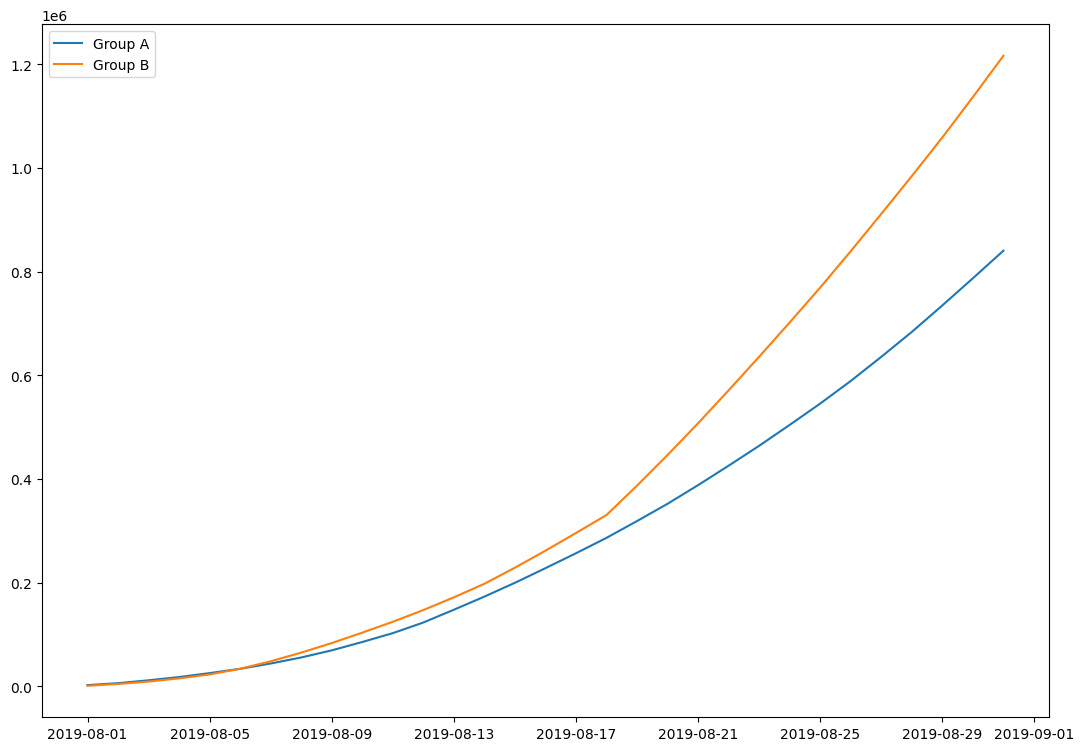

In [32]:
plt.rcParams["figure.figsize"] = (13,9)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['cumul_rev'], label='Group A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['cumul_rev'], label='Group B')
plt.legend()

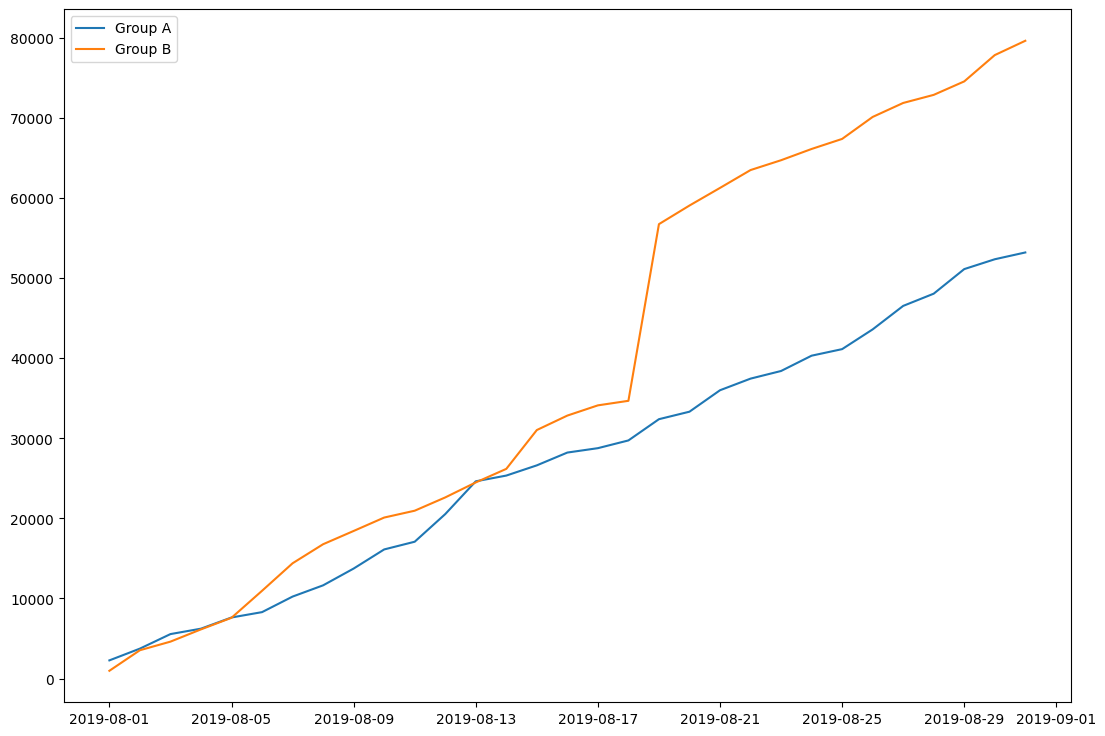

In [33]:
#general revenue per day 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Group A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Group B')
plt.legend()

The cumulative revenues between the groups starts out similar with B slightly leading.On 2019-08-19 (19th day of the test), group B had a very large revenue which leads to a large difference in cumulative revenues in the latter part the test. 

When looking at the graph of the total revenue for each day we can see the data fluctuating.  Sometimes Group A did better, sometimes group B.  Except for the 19th where we have a very large revenue in Group B.  Overall, group B is performing better.

### Graph cumulative average order size by group

In addition to knowing the revenue brought in by each group, we would like to know the average order size by customers in each group.  We will still do this with the cumulative revenue and the cumulative number of orders at each date.  
Below we will also check the daily average order size.

In [34]:
#calculating cumulative orders to calculate cumulative average check (cum. revenue / cum. orders)
cumulativeRevenueA['cumul_orders'] = cumulativeRevenueA['orders'].cumsum()
cumulativeRevenueA['cumul_avgchk'] = (cumulativeRevenueA['cumul_rev']/cumulativeRevenueA['cumul_orders']).round(2)
cumulativeRevenueA.head()

/tmp/ipykernel_51/3098188743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueA['cumul_orders'] = cumulativeRevenueA['orders'].cumsum()
/tmp/ipykernel_51/3098188743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueA['cumul_avgchk'] = (cumulativeRevenueA['cumul_rev']/cumulativeRevenueA['cumul_orders']).round(2)


,date,group,orders,buyers,revenue,visitors,cumul_rev,cumul_orders,cumul_avgchk
0,2019-08-01,A,23,19,2266.6,719,2266.6,23,98.55
40,2019-08-02,A,42,36,3734.9,1338,6001.5,65,92.33
82,2019-08-03,A,66,60,5550.1,1845,11551.6,131,88.18
120,2019-08-04,A,77,71,6225.6,2562,17777.2,208,85.47
145,2019-08-05,A,99,92,7623.6,3318,25400.8,307,82.74


In [35]:
cumulativeRevenueB['cumul_orders'] = cumulativeRevenueB['orders'].cumsum()
cumulativeRevenueB['cumul_avgchk'] = (cumulativeRevenueB['cumul_rev']/cumulativeRevenueB['cumul_orders']).round(2)
cumulativeRevenueB.head()

/tmp/ipykernel_51/2541823966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueB['cumul_orders'] = cumulativeRevenueB['orders'].cumsum()
/tmp/ipykernel_51/2541823966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueB['cumul_avgchk'] = (cumulativeRevenueB['cumul_rev']/cumulativeRevenueB['cumul_orders']).round(2)


,date,group,orders,buyers,revenue,visitors,cumul_rev,cumul_orders,cumul_avgchk
23,2019-08-01,B,17,17,967.2,713,967.2,17,56.89
59,2019-08-02,B,40,39,3535.3,1294,4502.5,57,78.99
106,2019-08-03,B,54,53,4606.9,1803,9109.4,111,82.07
131,2019-08-04,B,68,66,6138.5,2573,15247.9,179,85.18
167,2019-08-05,B,89,87,7587.8,3280,22835.7,268,85.21


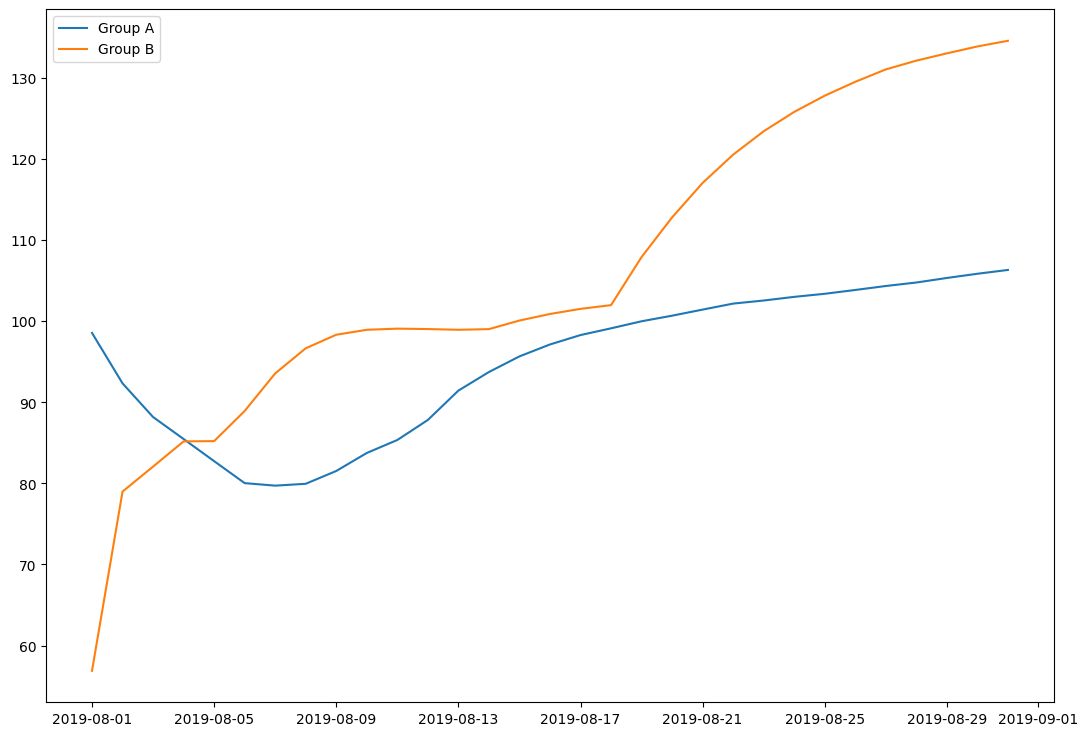

In [36]:
#plotting cumulative average check
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['cumul_avgchk'], label='Group A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['cumul_avgchk'], label='Group B')
plt.legend()

/tmp/ipykernel_51/3906469420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueA['avgchk']=cumulativeRevenueA['revenue']/cumulativeRevenueA['orders']
/tmp/ipykernel_51/3906469420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueB['avgchk']=cumulativeRevenueB['revenue']/cumulativeRevenueB['orders']


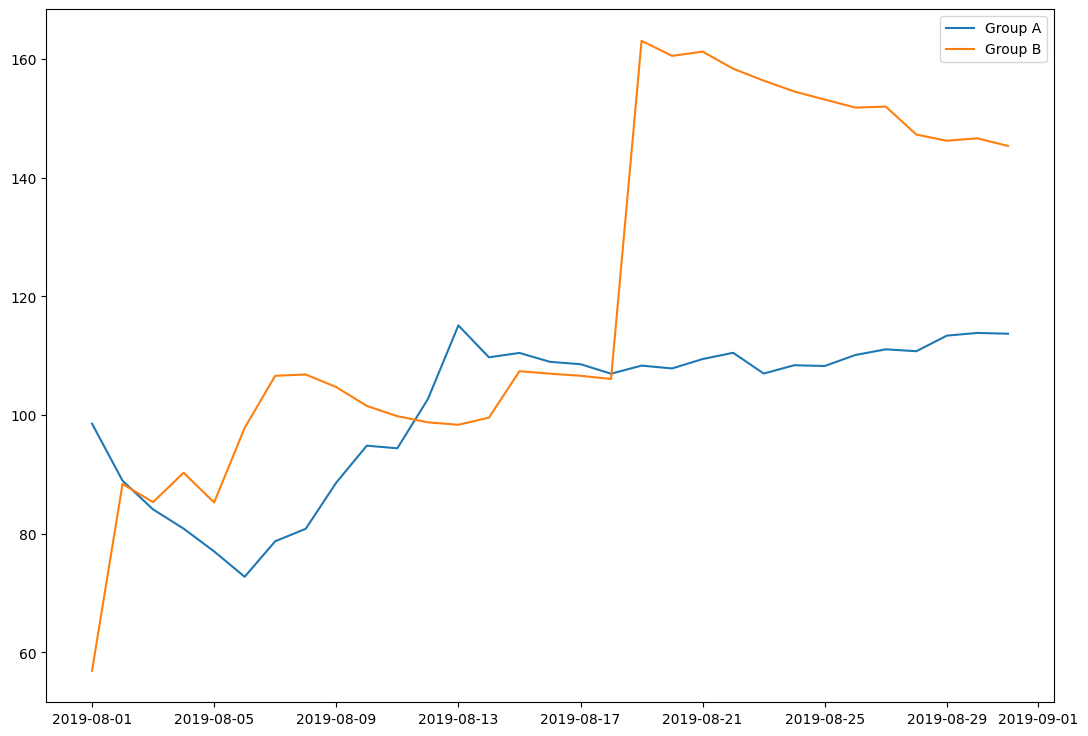

In [37]:
#plotting average check per day
cumulativeRevenueA['avgchk']=cumulativeRevenueA['revenue']/cumulativeRevenueA['orders']
cumulativeRevenueB['avgchk']=cumulativeRevenueB['revenue']/cumulativeRevenueB['orders']
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['avgchk'], label='Group A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['avgchk'], label='Group B')
plt.legend()

Group B has a larger cumulative average check most of the time over group A and is increasing over time.  It seems that this group at the end is more consistantly making larger purchases. 

Looking at the average check per day:  After some peaking in the middle of the test, group A stablizes around 115.  Group B on the other hand has a large peak in the middle of the month but then descreases slightly, finishing around 145 but is less stable than group A.

These peaks could point to influence from anomalies.

### Graph the relative difference in cumulative average order size for group B compared with group A.

To calculate the relative difference, it helps to have both groups in the same dataframe.

In [38]:
#merge dataframes with cumulative revenue and average check
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A','B'])
mergedCumulativeRevenue.head()

,date,groupA,ordersA,buyersA,revenueA,visitorsA,cumul_revA,cumul_ordersA,cumul_avgchkA,avgchkA,groupB,ordersB,buyersB,revenueB,visitorsB,cumul_revB,cumul_ordersB,cumul_avgchkB,avgchkB
0,2019-08-01,A,23,19,2266.6,719,2266.6,23,98.55,98.547826,B,17,17,967.2,713,967.2,17,56.89,56.894118
1,2019-08-02,A,42,36,3734.9,1338,6001.5,65,92.33,88.926190,B,40,39,3535.3,1294,4502.5,57,78.99,88.382500
2,2019-08-03,A,66,60,5550.1,1845,11551.6,131,88.18,84.092424,B,54,53,4606.9,1803,9109.4,111,82.07,85.312963
3,2019-08-04,A,77,71,6225.6,2562,17777.2,208,85.47,80.851948,B,68,66,6138.5,2573,15247.9,179,85.18,90.272059
4,2019-08-05,A,99,92,7623.6,3318,25400.8,307,82.74,77.006061,B,89,87,7587.8,3280,22835.7,268,85.21,85.256180


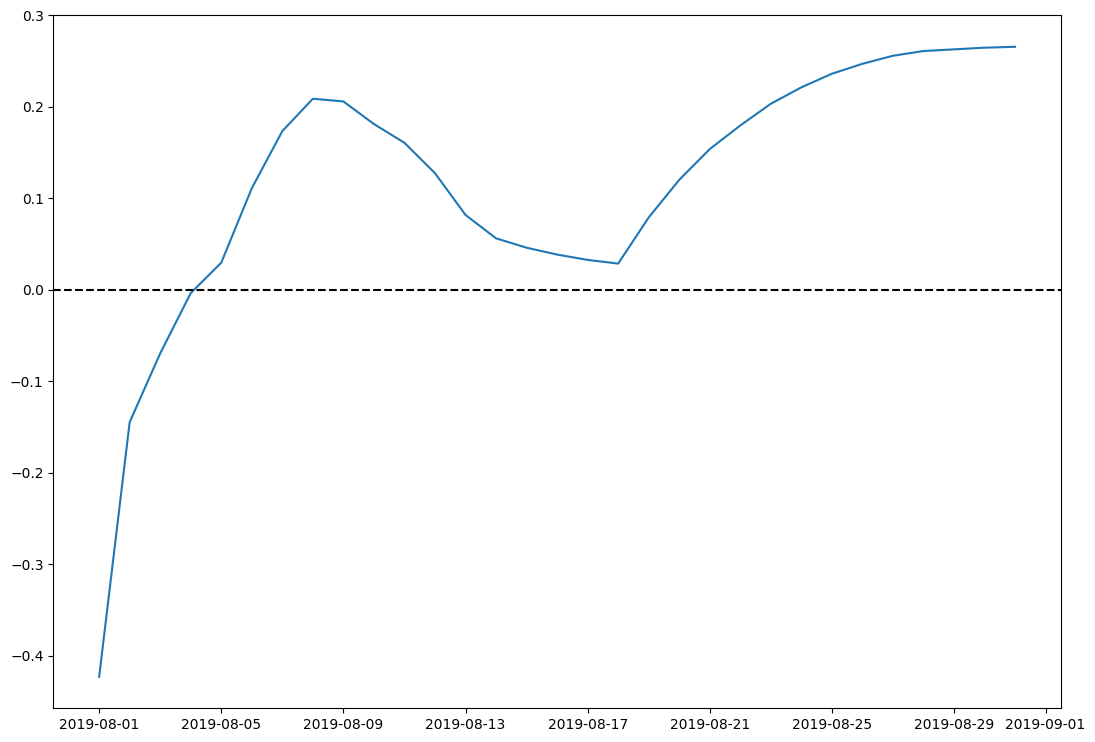

In [39]:
#graph relative difference of cumulative avg purchase size (cumulative avg check B / cumulative avg Chk A - 1)
plt.plot(mergedCumulativeRevenue['date'], mergedCumulativeRevenue['cumul_avgchkB']/mergedCumulativeRevenue['cumul_avgchkA'] - 1)
plt.axhline(y=0, color='black', linestyle= '--')

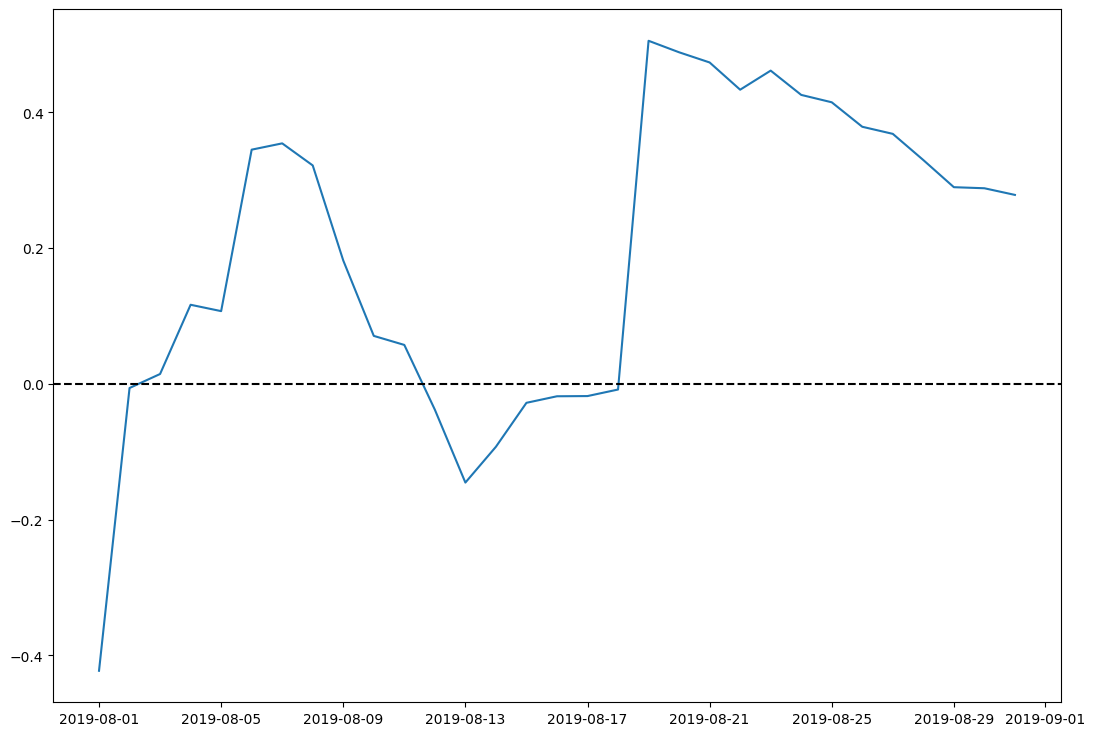

In [40]:
#graph relative difference of avg purchase size (avg check B / avg Chk A - 1)
plt.plot(mergedCumulativeRevenue['date'], mergedCumulativeRevenue['avgchkB']/mergedCumulativeRevenue['avgchkA'] - 1)
plt.axhline(y=0, color='black', linestyle= '--')

We can see from the relative difference in the two groups that from the early days of the test, group B had a higher cumulative average check over group A.  The peak in the beginning is when the average check of group B had a higher inital value.  On 2019-08-13, group A had a larger average check, seen as a trough in the middle of the graph.  At the end of the test, the curve flattens out pointing to a stabilization in average check for both groups.


### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference.

Looking first at cumulative conversion:

In [41]:
#A conversion column is added to each group so they can be plotted and analyzed.
cumulativeRevenueA['conversion'] = cumulativeRevenueA['buyers']/cumulativeRevenueA['visitors']
cumulativeRevenueB['conversion'] = cumulativeRevenueB['buyers']/cumulativeRevenueB['visitors']

/tmp/ipykernel_51/2832099924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueA['conversion'] = cumulativeRevenueA['buyers']/cumulativeRevenueA['visitors']
/tmp/ipykernel_51/2832099924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulativeRevenueB['conversion'] = cumulativeRevenueB['buyers']/cumulativeRevenueB['visitors']


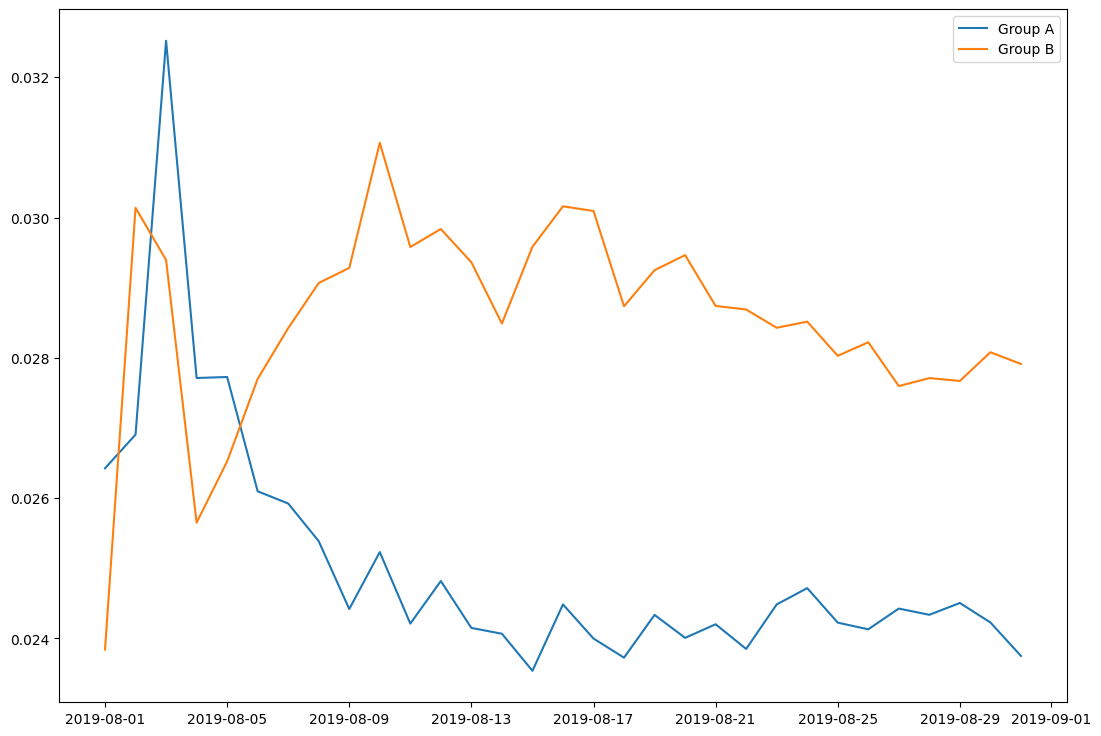

In [42]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['conversion'], label= 'Group A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['conversion'], label= 'Group B')
plt.legend()


After the recruitment period, group B has better conversion than group A.  Group B is stabilizing around 2.8% while group A stabilizes around 2.4%

Above is the cumulative conversion over time.  Let's plot the daily conversion using the users per day and relative difference in daily conversion between the groups.

In [43]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [44]:
ordersAgg = orders.groupby(['date', 'group'])['visitorId'].nunique().reset_index()
ordersAgg.columns = ['date', 'group', 'buyers']
ordersAgg

,date,group,buyers
0,2019-08-01,A,19
1,2019-08-01,B,17
2,2019-08-02,A,18
3,2019-08-02,B,22
4,2019-08-03,A,24
...,...,...,...
57,2019-08-29,B,15
58,2019-08-30,A,8
59,2019-08-30,B,21
60,2019-08-31,A,8


In [45]:
#merge dataframes, recalculate data conversion
visitsOrders = visits.merge(ordersAgg, how='left', on=['date', 'group'])
visitsOrders['conversion'] = visitsOrders['buyers']/visitsOrders['visits']
visitsOrders

,date,group,visits,buyers,conversion
0,2019-08-01,A,719,19,0.026426
1,2019-08-02,A,619,18,0.029079
2,2019-08-03,A,507,24,0.047337
3,2019-08-04,A,717,11,0.015342
4,2019-08-05,A,756,22,0.029101
...,...,...,...,...,...
57,2019-08-27,B,720,11,0.015278
58,2019-08-28,B,654,22,0.033639
59,2019-08-29,B,531,15,0.028249
60,2019-08-30,B,490,21,0.042857


In [46]:
#split into groups before plotting
visitsOrdersA = visitsOrders[visitsOrders['group']=='A']
visitsOrdersB = visitsOrders[visitsOrders['group']=='B']

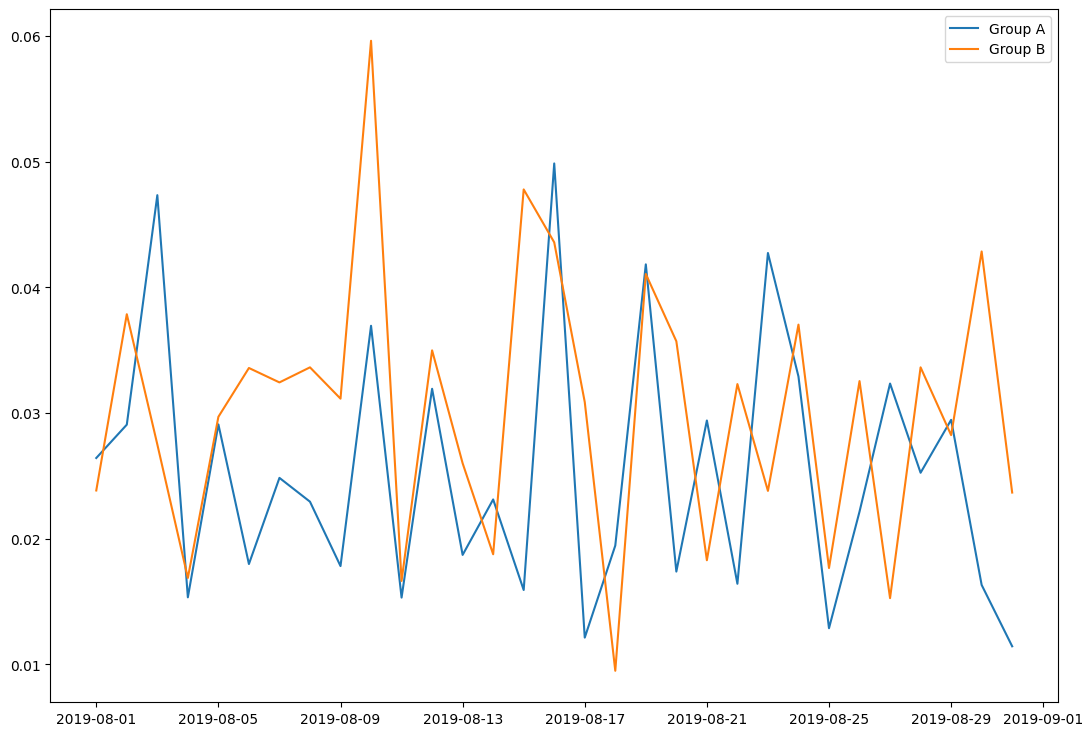

In [47]:
#conversion of groups
plt.plot(visitsOrdersA['date'], visitsOrdersA['conversion'], label= 'Group A')
plt.plot(visitsOrdersB['date'], visitsOrdersB['conversion'], label= 'Group B')
plt.legend()

In [48]:
#merge tables and look at conversion and data
mergedvisitsOrders = visitsOrdersA[['date', 'conversion']].merge(visitsOrdersB[['date', 'conversion']], left_on=['date'], right_on='date', how='left', suffixes=['A','B'])
mergedvisitsOrders.head()

,date,conversionA,conversionB
0,2019-08-01,0.026426,0.023843
1,2019-08-02,0.029079,0.037866
2,2019-08-03,0.047337,0.027505
3,2019-08-04,0.015342,0.016883
4,2019-08-05,0.029101,0.029703


In [49]:
mergedvisitsOrders.head()

,date,conversionA,conversionB
0,2019-08-01,0.026426,0.023843
1,2019-08-02,0.029079,0.037866
2,2019-08-03,0.047337,0.027505
3,2019-08-04,0.015342,0.016883
4,2019-08-05,0.029101,0.029703


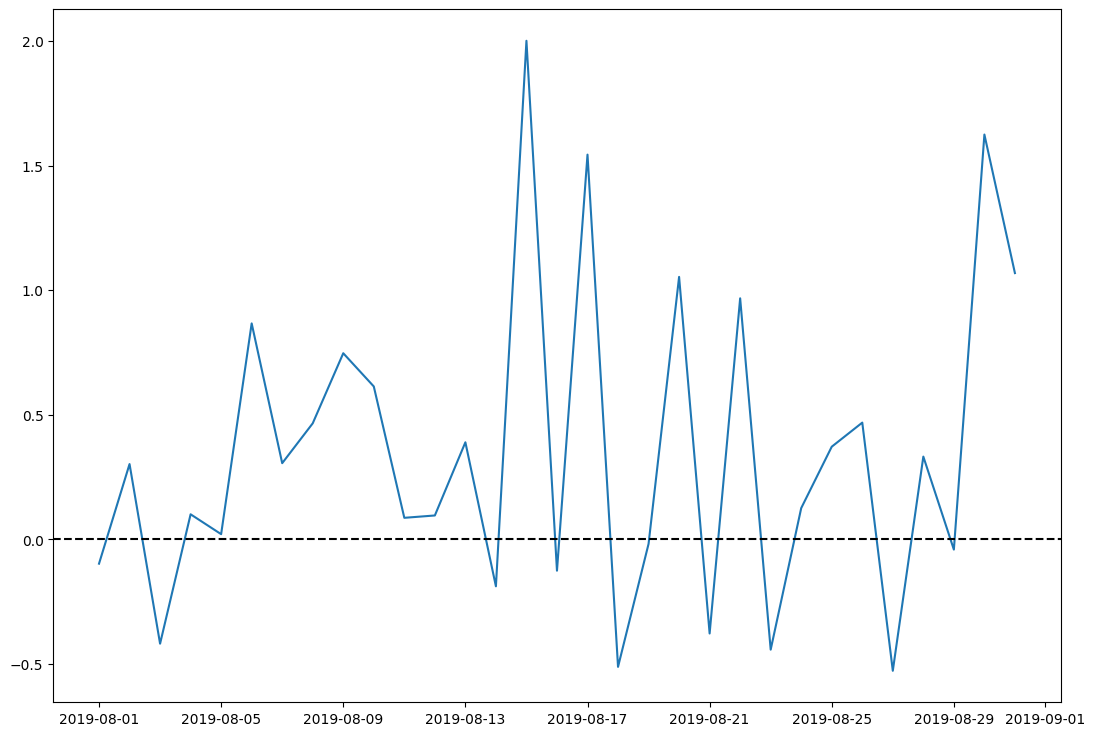

In [50]:
#plot difference in conversion
plt.plot(mergedvisitsOrders['date'], (mergedvisitsOrders['conversionB']/mergedvisitsOrders['conversionA'] -1))
plt.axhline(y=0, color='black', linestyle= '--')

The conversions for both groups fluctuate between .02 and .05.  Looking at the difference, despite group B's fluctuations, it mostly has a higher conversion than group A.

### Plot a scatter chart of the number of orders per user.

We see the conversion rate increased for group B and that the average check increased over time.  We can plot the number of orders per user to see if each order is making more purchases over time giving the higher values.

In [51]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [52]:
#drop irrelevant columns and calculate unique transactions for each visitor (buyer)
ordersByUser = (orders.drop(['group', 'revenue', 'date'], axis=1)
               .groupby('visitorId', as_index=False)
               .agg({'transactionId': pd.Series.nunique})
               )
ordersByUser.columns = ['visitorId', 'orders']
ordersByUser.head()

,visitorId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


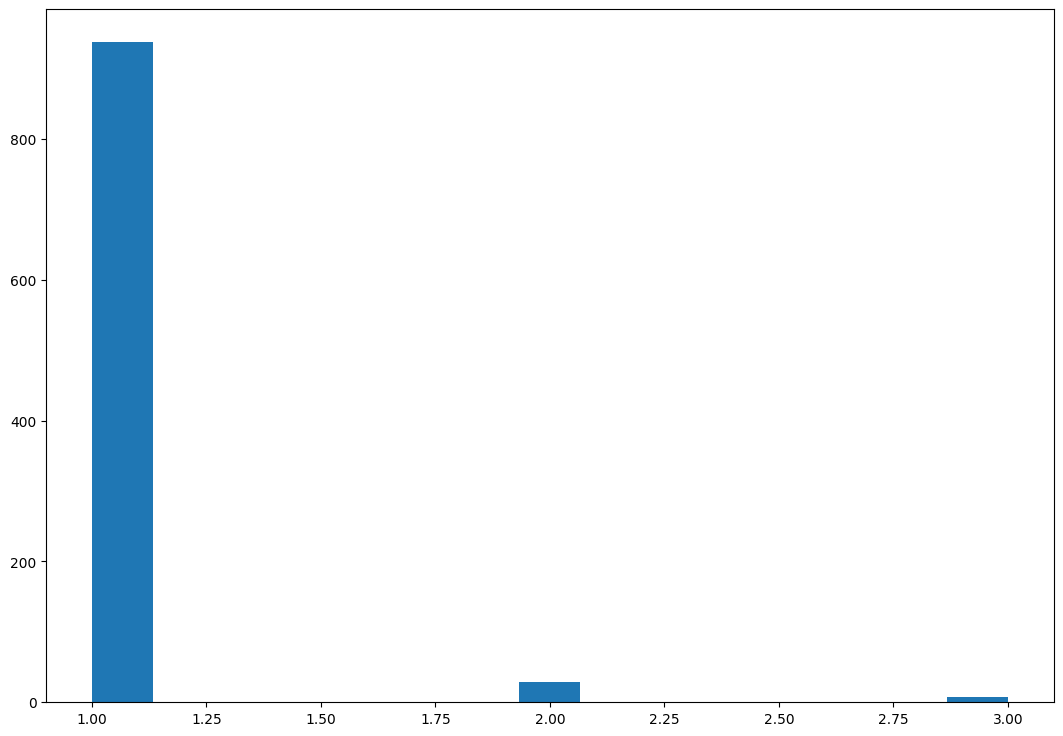

In [53]:
plt.hist(ordersByUser['orders'], bins=15)
plt.show()

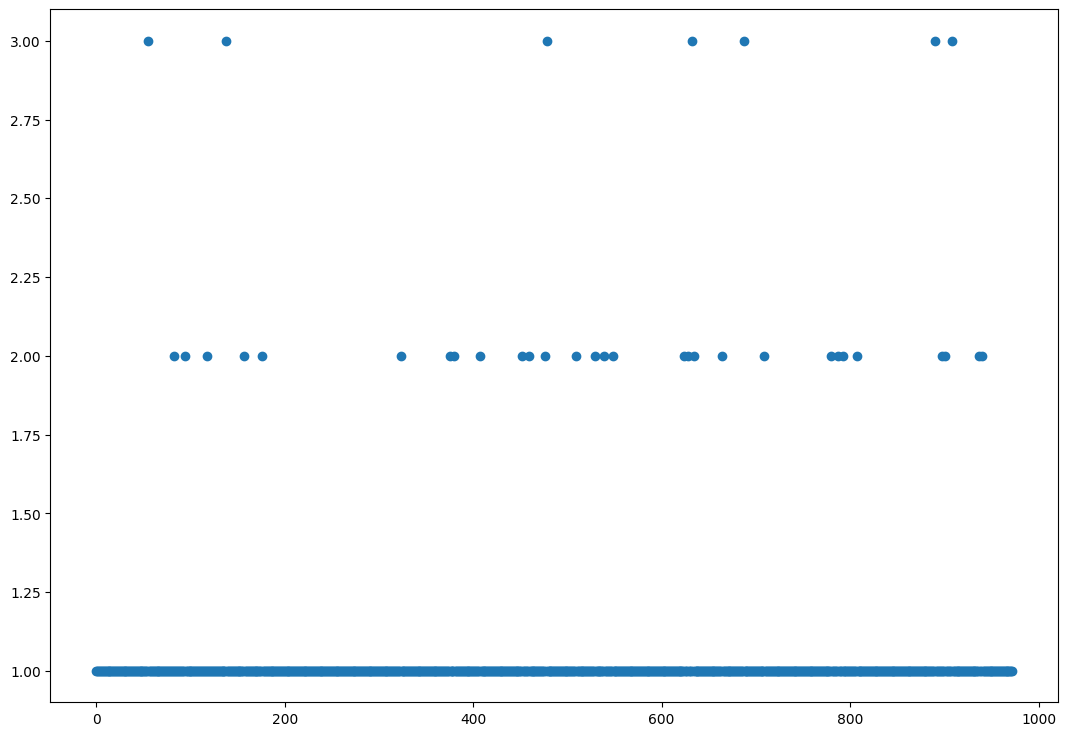

In [54]:
#create a range of values for the number of users that made x amount of purchases
x_values = pd.Series(range(0, len(ordersByUser)))
plt.scatter(x_values, ordersByUser['orders'])
plt.show()

Most users made just 1 purchase.  Some made 2 purchases and very few made more than two.  Lets see the percentiles they fall into so we can remove anomalies for the analysis.

### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

We calculate the percentile with the numpy percentile function to detect anomalies.

In [55]:
#calculate percentile
print(np.percentile(ordersByUser['orders'], [95, 99]))

[1. 2.]


# Only 5% of users make more than 1 purchase and 1% of users make more than 2 purchases.

It is reasonable to say that the 1% of users that made more than two purchases are the exception and can be removed.

### Plot a scatter chart of order prices.

In [56]:
ordersPrices = (orders.drop(['group', 'visitorId', 'date'], axis=1)
               .groupby('transactionId', as_index=False)
               .agg({'revenue': 'mean'})
               )
ordersPrices.columns = ['transactionId', 'revenue']
ordersPrices

,transactionId,revenue
0,1062393,100.8
1,4919758,40.2
2,7210578,60.5
3,8131427,75.5
4,11068804,75.7
...,...,...
1011,4256972642,35.6
1012,4261512099,50.8
1013,4279408906,15.8
1014,4281129020,60.2


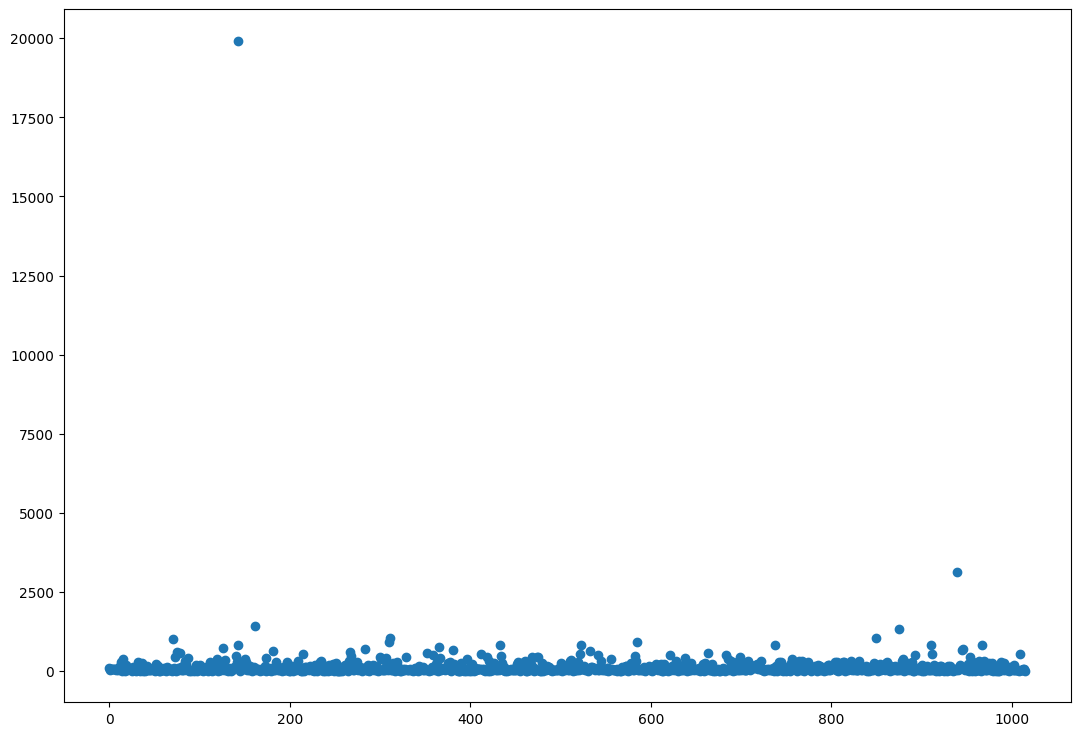

In [57]:
x_values_prices = pd.Series(range(0, len(ordersPrices)))
plt.scatter(x_values_prices, ordersPrices['revenue'])
plt.show()

In [58]:
#mean
print(orders['revenue'].mean())

130.77086614173228


In [59]:
#When was this large anomaly from? which group?
orders[orders['revenue']>15000]

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,19920.4,B


This scatterplot identifies an anomaly that really skewed our data.  There was a purchase of nearly $20,000 on 2019-08-19 from a user in group B.  This would explain the jump in revenue and average check for that date.

### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [60]:
#percentile for order prices
print(np.percentile(ordersPrices['revenue'], [95, 99]))

[414.275 830.3  ]


5% of buyers spent more than 415 in a single order and 1% spent more than 830.  More than 415 is considered an anomaly.  

Here is a scatterplot with the outliers (expensive orders) removed.

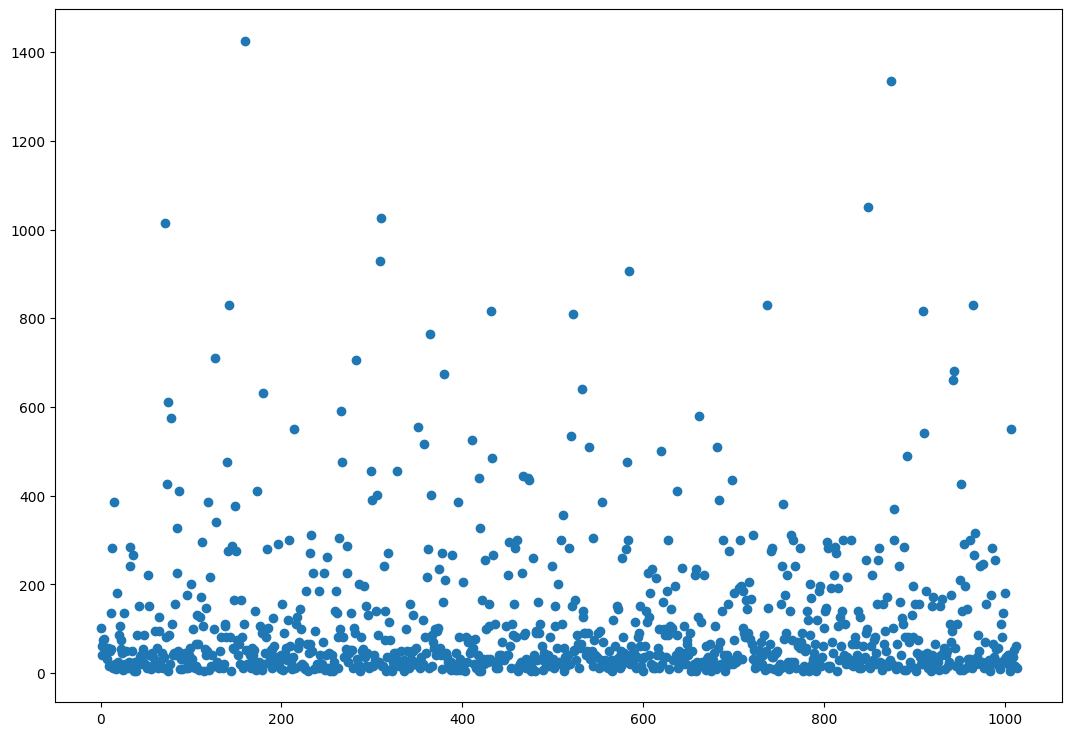

In [61]:
x_values_prices = pd.Series(range(0, (len(ordersPrices)-2)))
y_values_prices = ordersPrices[ordersPrices['revenue'] < 2500]['revenue']
plt.scatter(x_values_prices, y_values_prices)
plt.show()

### Find the statistical significance of the difference in conversion between the groups using the raw data.

Let's plot the daily conversion using the raw data using the merged tables before we calculate the statistical significance.

In [62]:
#use the merged dataframes of orders with daily visits with the daily conversion rates for the test.
mergedvisitsOrders.head()

,date,conversionA,conversionB
0,2019-08-01,0.026426,0.023843
1,2019-08-02,0.029079,0.037866
2,2019-08-03,0.047337,0.027505
3,2019-08-04,0.015342,0.016883
4,2019-08-05,0.029101,0.029703


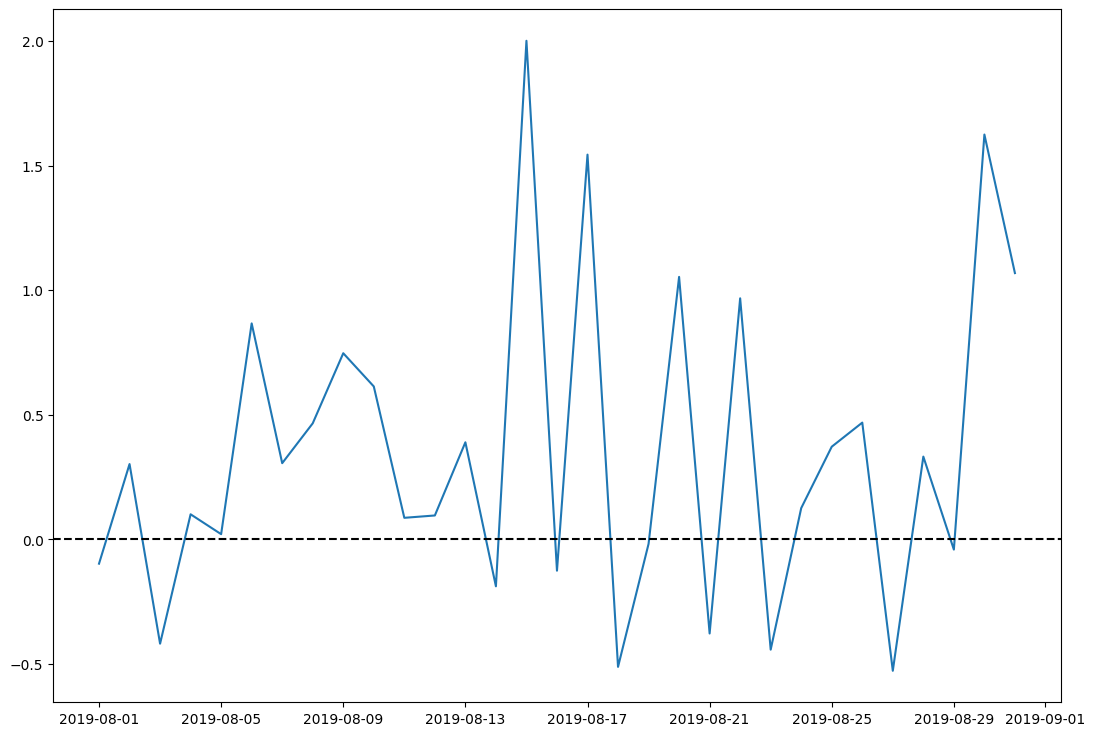

In [63]:
#plot difference in conversion
plt.plot(mergedvisitsOrders['date'], (mergedvisitsOrders['conversionB']/mergedvisitsOrders['conversionA'] -1))
plt.axhline(y=0, color='black', linestyle= '--')

The conversions for both groups fluctuate between .02 and .05.  Looking at the difference, despite group B's fluctuations, it mostly has a higher conversion than group A.

Now lets calculate the statistical significance to see if group B actually performed better than group A.

For the averages we will either test this using a t-test (if its a normal bell curve) or the Mann Whitney test (if it is a non normal curve).

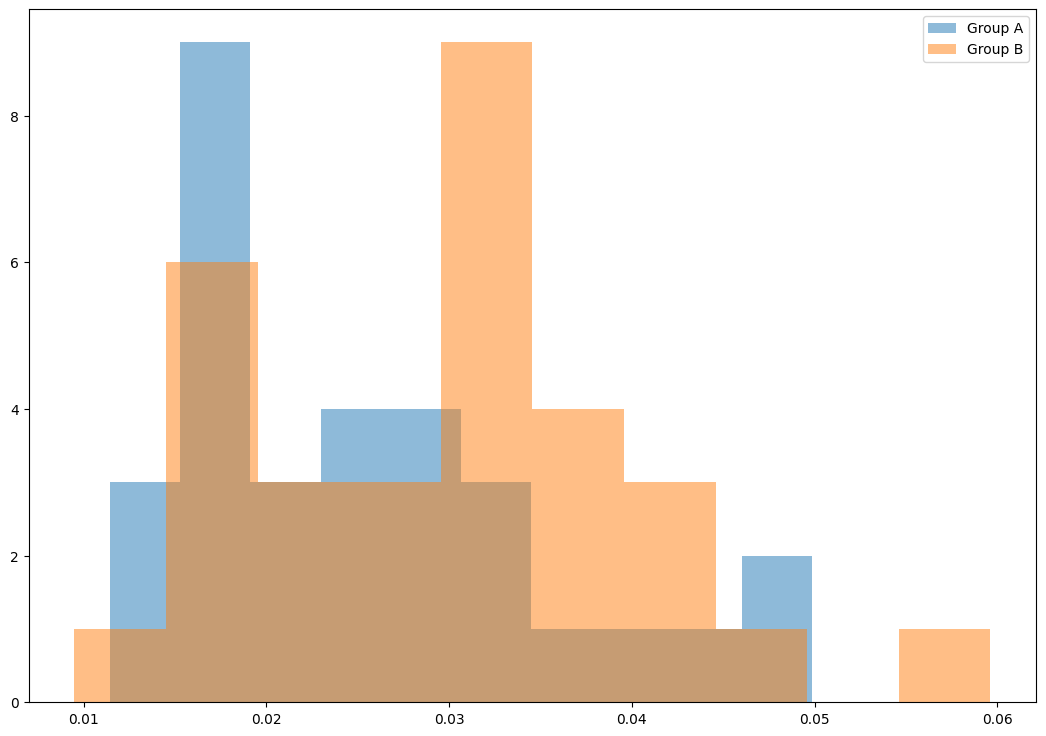

In [64]:
import random
import numpy
from matplotlib import pyplot


pyplot.hist(visitsOrdersA['conversion'], alpha=0.5, label='Group A')
pyplot.hist(visitsOrdersB['conversion'], alpha=0.5, label='Group B')
pyplot.legend(loc='upper right')
pyplot.show()

In [67]:
#testing daily conversion using the average
from scipy import stats
def testing_average(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=stats.shapiro(sample1)
    stat2, p2_norm=stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        print('conversion curves are normal t-test preformed)')
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        print('not normal curves, testing the median using mann whitney')
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    print(p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')

In [68]:
testing_average(visitsOrdersA['conversion'],visitsOrdersB['conversion'],alpha=0.05)

not normal curves, testing the median using mann whitney
0.038492032612519274
Reject H0


The conversion distribution curves are not normally distributed so the Mann Whitney test is used to test the hypotheses.

The p_value (3.8%) is less than 5% so the null hypothesis is rejected.  The groups came from different populations and group B's conversion is significantly better than group A.

### Find the statistical significance of the difference in average order size between the groups using the raw data. 

Since we are looking at average order size and the distribution curve is not normal, we will use the mann whitney test to test the statistical significance

In [69]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [70]:
orders_A = orders[orders['group']=='A']
orders_B = orders[orders['group']=='B']

In [71]:
orders_A.head()

,transactionId,visitorId,date,revenue,group
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
10,3649131742,879864040,2019-08-15,65.7,A
12,2809384911,3213223594,2019-08-15,115.4,A
14,3859315276,1565034404,2019-08-15,170.9,A


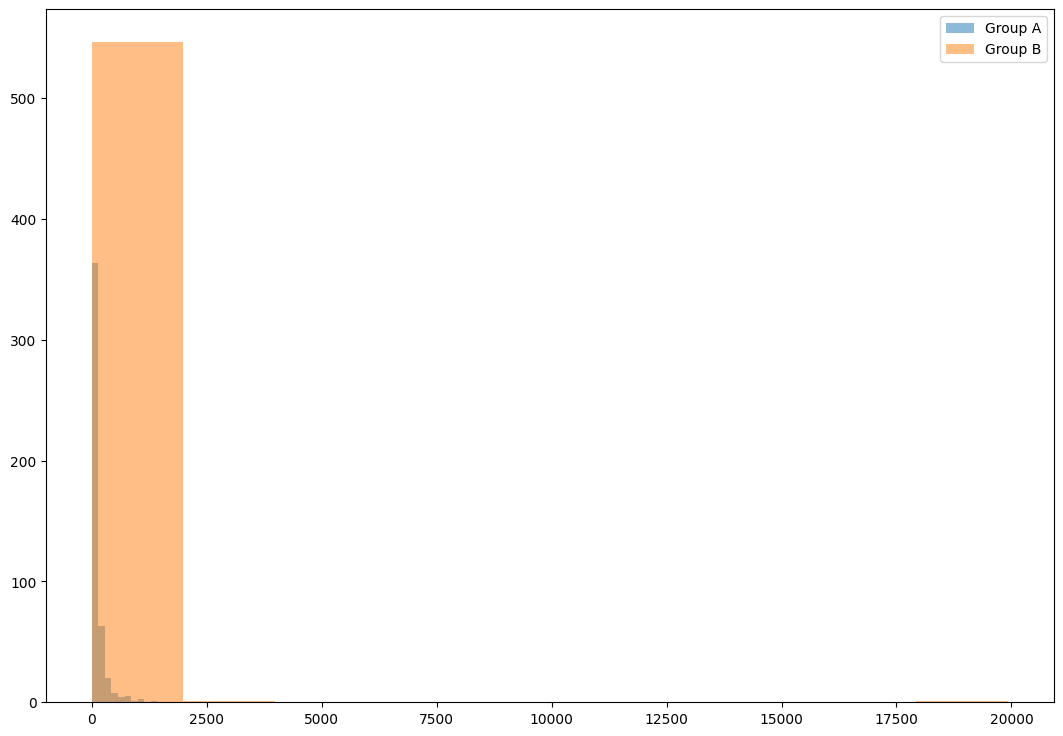

In [72]:
pyplot.hist(orders_A['revenue'], alpha=0.5, label='Group A')
pyplot.hist(orders_B['revenue'], alpha=0.5, label='Group B')
pyplot.legend(loc='upper right')
pyplot.show()

In [73]:
#use the testing_average formula to test statistical significance of average order size (average check)
testing_average(orders_A['revenue'],orders_B['revenue'],alpha=0.05)

not normal curves, testing the median using mann whitney
0.8622329690015668
Fail to Reject H0


In [74]:
#group A median avg check
orders_A['revenue'].median()

50.1

In [75]:
#group B median avg check
orders_B['revenue'].median()

45.9

Since the curve is not normal, the median gives a better average.
The average order size is higher for group A (50.1), and lower for group B (45.9).
The p-value (86.2%) is more than 5% so we fail reject the null hypothesis and conclude that the higher average for group A is not statistically significant.

### Find the statistical significance of the difference in conversion between the groups using the filtered data.

Before we can look at the difference in conversion, we need to filter the data according to the 95th percentile, removing all outliers.

In this case we will keep only all orders that ordered 2 or less items and had an order price of less than 415.

In [76]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [77]:
#show the number of orders from each user, group A
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

In [78]:
#show the number of orders from each user, group A
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [79]:
#filter out the ordersByUsers table to identify users with more than two orders.
#concat the tables into one table
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)

In [80]:
#filter out the orders table to identify users purchases more than $415
usersWithExpensiveOrders = orders[orders['revenue'] > 415]['visitorId']

In [81]:
#create a list of abnormal users who bought more than two items or made orders totaling more than $415
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: int64


In [82]:
#orders table for group A filtered to include only normal users
ordersA_filtered = orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]    
ordersA_filtered.head()

,transactionId,visitorId,date,revenue,group
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
10,3649131742,879864040,2019-08-15,65.7,A
12,2809384911,3213223594,2019-08-15,115.4,A
14,3859315276,1565034404,2019-08-15,170.9,A


In [83]:
#orders table for group B filtered to include only normal users
ordersB_filtered = orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
ordersB_filtered.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


Now that we have the filtered dataset, we need to remove the excess visits from the visits table for each date.

In [84]:
orders_filtered = pd.concat([ordersA_filtered, ordersB_filtered])
orders_filtered

,transactionId,visitorId,date,revenue,group
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
10,3649131742,879864040,2019-08-15,65.7,A
12,2809384911,3213223594,2019-08-15,115.4,A
14,3859315276,1565034404,2019-08-15,170.9,A
...,...,...,...,...,...
1181,1303723408,3218863961,2019-08-14,390.5,B
1186,2116724386,2146711261,2019-08-14,240.6,B
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B


In [85]:
#use the dates and groups from datesGroups to aggregate the values in orders table and sort by date and group.
ordersFilteredAgg = orders_filtered.apply(
    lambda x: orders_filtered[
        np.logical_and(
            orders_filtered['date'] <= x['date'], orders_filtered['group']==x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue':'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group']).drop_duplicates()

In [86]:
ordersFilteredAgg.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,16,15,883.2
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,34,32,2321.5
174,2019-08-02,B,38,37,2469.7
291,2019-08-03,A,58,56,4136.7


Comparing the two dataframes above we can see that when we removed anomalies from the orders table, the number of transactions (orders), the number of unique visitors (buyers) and the revenue all decreased.

In [87]:
#merge ordersFilteredAgg with visits and recalculate daily conversions and repeat mann-whitney test
mergedVisitsOrdersFilteredAgg = visits.merge(ordersFilteredAgg, how='left', on=['date', 'group'])
mergedVisitsOrdersFilteredAgg.columns = ['date', 'group', 'visits', 'orders', 'unique_buyers', 'revenue']

In [88]:
#conversion = buyers/visitors  
#Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. 
mergedVisitsOrdersFilteredAgg['conversion'] = mergedVisitsOrdersFilteredAgg['orders']/mergedVisitsOrdersFilteredAgg['visits']
mergedVisitsOrdersFilteredAgg

,date,group,visits,orders,unique_buyers,revenue,conversion
0,2019-08-01,A,719,16,15,883.2,0.022253
1,2019-08-02,A,619,34,32,2321.5,0.054927
2,2019-08-03,A,507,58,56,4136.7,0.114398
3,2019-08-04,A,717,69,67,4812.2,0.096234
4,2019-08-05,A,756,91,88,6210.2,0.120370
...,...,...,...,...,...,...,...
57,2019-08-27,B,720,442,429,34319.1,0.613889
58,2019-08-28,B,654,464,449,35329.6,0.709480
59,2019-08-29,B,531,479,463,37010.8,0.902072
60,2019-08-30,B,490,497,481,38526.6,1.014286


In [89]:
#Plot the daily conversion rates of the two groups and describe the difference.

In [90]:
mergedVisitsOrdersFilteredAggA = mergedVisitsOrdersFilteredAgg[mergedVisitsOrdersFilteredAgg['group']=='A']
mergedVisitsOrdersFilteredAggB = mergedVisitsOrdersFilteredAgg[mergedVisitsOrdersFilteredAgg['group']=='B']

In [91]:
mergedVisitsOrdersFilteredAggA.head()

,date,group,visits,orders,unique_buyers,revenue,conversion
0,2019-08-01,A,719,16,15,883.2,0.022253
1,2019-08-02,A,619,34,32,2321.5,0.054927
2,2019-08-03,A,507,58,56,4136.7,0.114398
3,2019-08-04,A,717,69,67,4812.2,0.096234
4,2019-08-05,A,756,91,88,6210.2,0.120370


In [92]:
mergedVisitsOrdersFilteredAggA['conversion'].median()

0.3787425149700599

In [93]:
mergedVisitsOrdersFilteredAggB['conversion'].median()

0.5013550135501355

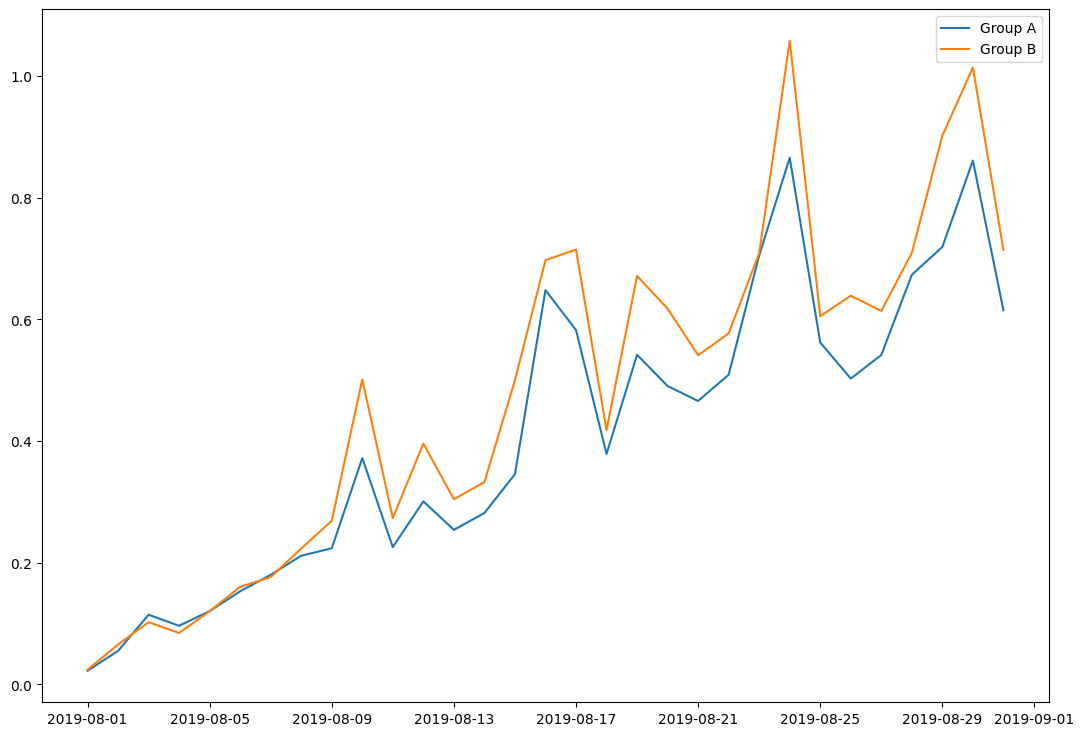

In [94]:
plt.plot(mergedVisitsOrdersFilteredAggA['date'], mergedVisitsOrdersFilteredAggA['conversion'], label= 'Group A')
plt.plot(mergedVisitsOrdersFilteredAggB['date'], mergedVisitsOrdersFilteredAggB['conversion'], label= 'Group B')
plt.legend()


In [95]:
testing_average(mergedVisitsOrdersFilteredAggA['conversion'],mergedVisitsOrdersFilteredAggB['conversion'],alpha=0.05)

conversion curves are normal t-test preformed)
0.3090637763035816
Fail to Reject H0


After removing outliers, Group B has a higher median conversion (.50) than group A (.37).

We can see on the graph that the conversion rates for group B are consistantly slightly above group A.

Unfortunately, the new averages for conversion from groups A and B have a p-value above 5% (30.9%) so we fail to reject the null hypothesis and conclude that the higher conversion for group B is not statistically significant.

### Find the statistical significance of the difference in average order size between the groups using the filtered data.

In [96]:
#do the same thing that I did above but with the filtered orders. to do the average order size

In [97]:
print('average check group A: ', orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean())

average check group A:  81.60023255813955


In [98]:
print('average check group B: ', orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean())

average check group B:  77.73645224171541


In [99]:
#mann whitney test to find the average check for transactions among normal users (filtered out abnormal users)
print('p-value between groups:', '{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

p-value between groups: 0.680


In [100]:
#difference between revenue of group A and B
print('{0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

-0.047


In [101]:
#using the testing average formula with the filtered data to test statistical significance for average check.
testing_average(ordersA_filtered['revenue'],ordersB_filtered['revenue'],alpha=0.05)

not normal curves, testing the median using mann whitney
0.6802866355131224
Fail to Reject H0


When we removed the anomalies from the group, group B's average check (77.7) fell below that of group A (81.6).  The p-value between the groups for their average order size (68%) is more than 5% so we fail to reject the null hypothesis so we can't prove that any difference was statistically significant.

## Conclusions

A/B tests were initiated to test if the changes suggested by the hypotheses were effective.  However, several difficulties and anomalies in the data made it difficult to interpet the results.

Users that showed up in both groups needed to removed from the test.  This resulted in a 15% loss in data and changed the conversion rates and average order size.

Looking at the raw data, group B had a higher conversion and stabilized cumulative average order size over group A (2.8% vs 2.4% and 145 vs 115).  
When the daily conversion and average order size were compared, similar trends were observed.

When tested with the test of proportions the conversion advantage of group B was statistically significant.  However the average order size was not significant when tested with the Mann-Whitney test.

The average order size stabized at 115 for group A and 145 for group B.  However, interesting peaks and troughs in these graphs pointed to some sort of interference.  Sure enough when the average order sizes and revenue were examined, several anomalies were discovered.  In group B there was a single order on 2019-08-19 for $20,000 that skewed the average order size completely.  Additionally buyers that bought many times changed the conversion.

The data was filtered to remove all orders of more than $415 and all orders of more than 2 items. 
Upon filtering, group B still had a higher conversion (50% over 37%) but had a very high p-value so this victory was not statistically significant.
Similarily, when we removed the anomalies from the group, group B's average check fell below group A.  The p-value between the groups for their average order size (68%) was more than 5% so we failed to reject the null hypothesis so we can't prove that any difference was statistically significant.

<b>Verdict</b><br>
We advise to stop the test as there is no statistically signicant difference between the groups.